In [131]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import add_constant
from statsmodels.api import OLS

## Implement the PELT algorithm for a general log-likelihood

In [132]:
def find_min(arr, val=0.0):
    return min(arr) + val, np.argmin(arr)

def pelt(cost, length, pen=None):
    if pen is None:
        pen = np.log(length)

    F = np.zeros(length + 1)
    R = np.array([0], dtype=int)
    candidates = np.zeros(length + 1, dtype=int)

    F[0] = -pen

    for tstar in range(2, length + 1):
        cpt_cands = R
        seg_costs = np.zeros(len(cpt_cands))
        for i in range(0, len(cpt_cands)):
            seg_costs[i] = cost(cpt_cands[i], tstar)

        F_cost = F[cpt_cands] + seg_costs
        F[tstar], tau = find_min(F_cost, pen)
        candidates[tstar] = cpt_cands[tau]

        ineq_prune = [val < F[tstar] for val in F_cost]
        R = [cpt_cands[j] for j, val in enumerate(ineq_prune) if val]
        R.append(tstar - 1)
        R = np.array(R, dtype=int)

    last = candidates[-1]
    changepoints = [last]
    while last > 0:
        last = candidates[last]
        changepoints.append(last)

    return sorted(changepoints)


The log-likelihood will come from a linear regression model with an intercept and a single linearly increasing covariate.

In [133]:
def trender(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    def cost(start, end):
        invar = np.arange(end - start)
        invar = add_constant(invar)
        model = OLS(data[start:end], invar)
        model_fit = model.fit()

        #print(start, end, model_fit.llf)
        return(-model_fit.llf)
    return cost


## Generate some test data

In [134]:
#Generate data
dt = 0.001
alpha1 = 1.0
alpha2 = 1.5
alpha3 = 2.0

t = np.arange(0,1, dt)
N = len(t)
cp1 = int(0.35*N)
cp2 = int(0.85*N)

In [135]:
sample = np.zeros(len(t))
sample[:cp1] = alpha1*t[:cp1]+0.20*np.random.randn(cp1)
sample[cp1:cp2] = alpha2*(t[cp1:cp2]-t[cp1]) + 0.20*np.random.randn(cp2-cp1)
sample[cp2:] = alpha3*(t[cp2:]-t[cp2]) + 0.20*np.random.randn(N-cp2)

sample = sample

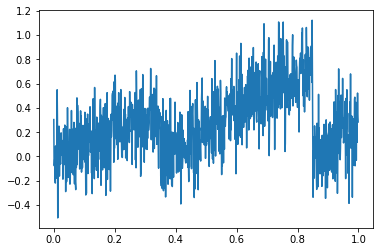

In [136]:
plt.plot(t, sample)

In [124]:
ccost = trender(sample)
indices = pelt(ccost, len(sample), pen=70)

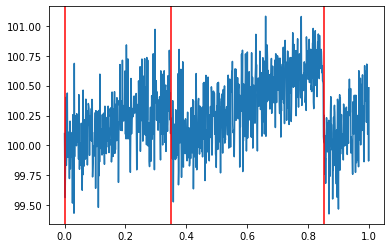

In [125]:
plt.plot(t, sample)
for i in indices:
    plt.axvline(t[i], color='red')

#plt.axvline(cp1, color='black')
#plt.axvline(cp2, color='black')